Importowanie bibliotek

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from gensim.models import Word2Vec
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from gensim.models import Word2Vec

Ustawienia wykresów

In [ ]:
sns.set(style="whitegrid")

Zetsaw cech używany w analizie

In [ ]:
features = [
    "danceability", "energy", "loudness", "speechiness", "acousticness",
    "instrumentalness", "valence", "tempo", "popularity"
]

Pobieranie i wstępne przetwarzanie danych

In [ ]:
# Funkcja do pobierania i weryfikacji plików
def download_and_get_csv_path(dataset_name, version_path="/root/.cache/kagglehub/datasets"):
    """
    Pobiera dane z Kaggle i zwraca ścieżkę do pliku CSV.
    """
    # Pobieranie najnowszej wersji zestawu danych
    dataset_path = kagglehub.dataset_download(dataset_name)
    #print("Path to dataset files:", dataset_path)

    # Weryfikacja i lokalizacja pliku CSV
    csv_file = None
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".csv"):
                csv_file = os.path.join(root, file)
                break
        if csv_file:
            break

    if not csv_file:
        raise FileNotFoundError(f"Nie znaleziono pliku CSV w katalogu {dataset_path}.")

    return csv_file

# Funkcja do wczytywania i przetwarzania danych
def load_and_preprocess_data(dataset_path):
    """
    Wczytuje dane i przeprowadza wstępne przetwarzanie.
    Normalizuje tekst, usuwa duplikaty i brakujące wartości.
    """
    data = pd.read_csv(dataset_path)

    # Funkcja normalizująca tekst
    def normalize_unicode(text):
        if isinstance(text, str):
            return unicodedata.normalize("NFKD", text).strip().lower()
        return text

    # Normalizacja i usuwanie duplikatów
    data["track_name"] = data["track_name"].apply(normalize_unicode)
    data["artists"] = data["artists"].apply(normalize_unicode)

    # Usunięcie duplikatów i braków danych
    data = (
        data.drop_duplicates(subset=["track_name", "artists"])
            .dropna(subset=["track_name", "artists"])
            .reset_index(drop=True)
    )

    return data

# Główna logika
try:
    dataset_name = "maharshipandya/-spotify-tracks-dataset"
    csv_path = download_and_get_csv_path(dataset_name)
    data = load_and_preprocess_data(csv_path)
    #print(f"Dane załadowane pomyślnie. Liczba rekordów: {len(data)}")
except FileNotFoundError as e:
    print(f"Błąd: {e}")
except Exception as e:
    print(f"Wystąpił nieoczekiwany błąd: {e}")


100%|██████████| 8.17M/8.17M [00:00<00:00, 27.1MB/s]

Extracting files...


Skalowanie danych

In [ ]:
def scale_features(data, features):
    """
    Skalowanie cech numerycznych.
    """
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(data[features])
    scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=data.index)
    return pd.concat([data[["track_id", "track_name", "track_genre"]], scaled_features_df], axis=1)

scaled_data = scale_features(data, features)

Tworzenie historii

In [ ]:
def prepare_genre_embeddings(data, numerical_features):
    """
    Tworzy osadzenia Word2Vec na podstawie unikalnych gatunków.
    """
    # Grupowanie według gatunku
    genre_features = data.groupby('track_genre')[numerical_features].mean()
    genres = data["track_genre"].unique().tolist()
    genre_corpus = [[genre] for genre in genres]

    # Trening modelu Word2Vec
    word2vec_model = Word2Vec(sentences=genre_corpus, vector_size=100, window=3, min_count=1, sg=1, seed=42)

    # Uzyskanie osadzeń dla każdego gatunku
    genre_embeddings = {genre: word2vec_model.wv[genre] for genre in genres}

    return genre_features, genre_embeddings

def combine_features(genre_features, genre_embeddings):
    """
    Łączy cechy numeryczne z osadzeniami Word2Vec.
    """
    combined_features = np.hstack([
        genre_features.values,
        np.array([genre_embeddings[genre] for genre in genre_features.index])
    ])
    return combined_features

def cluster_genres(combined_features, n_clusters=10):
    """
    Klasteryzacja gatunków za pomocą K-Means.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(combined_features)
    return clusters

In [ ]:
scaled_data = scale_features(data, features)

# Przygotowanie osadzeń gatunków
genre_features, genre_embeddings = prepare_genre_embeddings(scaled_data, features)

# Połączenie cech
combined_features = combine_features(genre_features, genre_embeddings)
clusters = cluster_genres(combined_features, n_clusters=10)
genre_to_cluster = {genre: cluster for genre, cluster in zip(genre_features.index, clusters)}
print(genre_to_cluster)
# for genre in genre_features.index:
#       print(genre)

{'acoustic': 1, 'afrobeat': 9, 'alt-rock': 3, 'alternative': 3, 'ambient': 2, 'anime': 9, 'black-metal': 0, 'bluegrass': 1, 'blues': 1, 'brazil': 1, 'breakbeat': 5, 'british': 1, 'cantopop': 1, 'chicago-house': 9, 'children': 1, 'chill': 1, 'classical': 2, 'club': 9, 'comedy': 8, 'country': 1, 'dance': 4, 'dancehall': 4, 'death-metal': 5, 'deep-house': 9, 'detroit-techno': 6, 'disco': 4, 'disney': 2, 'drum-and-bass': 5, 'dub': 3, 'dubstep': 3, 'edm': 3, 'electro': 1, 'electronic': 9, 'emo': 3, 'folk': 1, 'forro': 4, 'french': 1, 'funk': 4, 'garage': 3, 'german': 9, 'gospel': 1, 'goth': 3, 'grindcore': 0, 'groove': 3, 'grunge': 3, 'guitar': 2, 'happy': 5, 'hard-rock': 3, 'hardcore': 3, 'hardstyle': 5, 'heavy-metal': 3, 'hip-hop': 4, 'honky-tonk': 7, 'house': 3, 'idm': 6, 'indian': 1, 'indie': 1, 'indie-pop': 1, 'industrial': 3, 'iranian': 6, 'j-dance': 4, 'j-idol': 3, 'j-pop': 1, 'j-rock': 3, 'jazz': 7, 'k-pop': 1, 'kids': 4, 'latin': 4, 'latino': 4, 'malay': 1, 'mandopop': 1, 'metal': 

In [ ]:
def generate_random_history(data, user_id, n_songs=250):
    """
    Tworzy losową historię ocen użytkownika w skali 1-5.
    """
    user_history = data.sample(n_songs).copy()
    user_history["rating"] = np.random.uniform(0, 5, size=n_songs)  # Oceny w skali 1-5
    user_history["user_id"] = user_id
    return user_history[["user_id", "track_id", "rating"]]


def generate_genre_based_history(data, user_id, n_songs=250, alpha=0.05, start_genre=None):
    """
    Tworzy historię ocen opartą na preferencjach gatunkowych w skali 1-5.
    """
    genres = data["track_genre"].unique()
    current_genre = start_genre if start_genre else random.choice(genres)
    rated_songs = []
    current_rating = random.uniform(0, 5)  # Startowa ocena w skali 0-5

    genre_ratings = {}
    cluster_ratings = {}

    for _ in range(n_songs):
        genre_songs = data[data["track_genre"] == current_genre]
        current_song = genre_songs.sample(1).iloc[0]

        rated_songs.append({
            "user_id": user_id,
            "track_id": current_song["track_id"],
            "rating": current_rating
        })

        if random.random() < alpha:
            current_genre = random.choice([g for g in genres if g != current_genre])
            if current_genre in genre_ratings:
                temp_rating = genre_ratings[current_genre] + random.uniform(-0.5, 0.5)
                temp_rating = max(0, min(5, temp_rating))
                current_rating = temp_rating
                current_cluster = genre_to_cluster[current_genre]
                cluster_ratings[current_cluster] = current_rating
                genre_ratings[current_genre] = max(0, min(5, temp_rating))
            else:
                current_cluster = genre_to_cluster[current_genre]
                if current_cluster in cluster_ratings:
                    current_rating = cluster_ratings[current_cluster] + random.uniform(-0.5, 0.5)
                    current_rating = max(0, min(5, current_rating))
                    cluster_ratings[current_cluster] = current_rating
                    genre_ratings[current_genre] = current_rating
                else:
                    current_rating = random.uniform(0, 5)
                    cluster_ratings[current_cluster] = current_rating
                    genre_ratings[current_genre] = current_rating


            # current_rating = max(0, min(5, random.uniform(0, 5) ))  # Zmień ocenę przy zmianie gatunku
        else:
            current_rating += random.uniform(-0.5, 0.5)  # Niewielka zmiana oceny
            current_rating = round(max(0, min(5, current_rating)))  # Zaokrąglenie do skali 0-5

            genre_ratings[current_genre] = current_rating

    return pd.DataFrame(rated_songs)

Wizualizacja ocen

In [ ]:
def scatter_songs_with_tsne(user_history, scaled_data, features, i):
    """
    Wizualizacja utworów z ocenami użytkownika w t-SNE.
    """
    # Łączenie historii z danymi po track_id
    merged_df = user_history.merge(scaled_data, on="track_id")

    # Ekstrakcja cech numerycznych i ocen
    features = merged_df[features].values
    ratings = merged_df["rating"].values

    # Redukcja wymiarów za pomocą t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=10, max_iter=500)
    reduced_features = tsne.fit_transform(features)

    # Tworzenie wykresu
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        reduced_features[:, 0], reduced_features[:, 1],
        c=ratings, cmap="viridis", edgecolor='k', alpha=0.8
    )
    plt.colorbar(scatter, label="Rating")
    if i == 0:
        plt.title("Random User History Visualization", fontsize=16)
    else:
        plt.title("Genre-Based User History Visualization", fontsize=16)
    #plt.title("t-SNE Visualization of User Ratings", fontsize=16)
    plt.grid(True)
    plt.show()

Random User History Visualization:


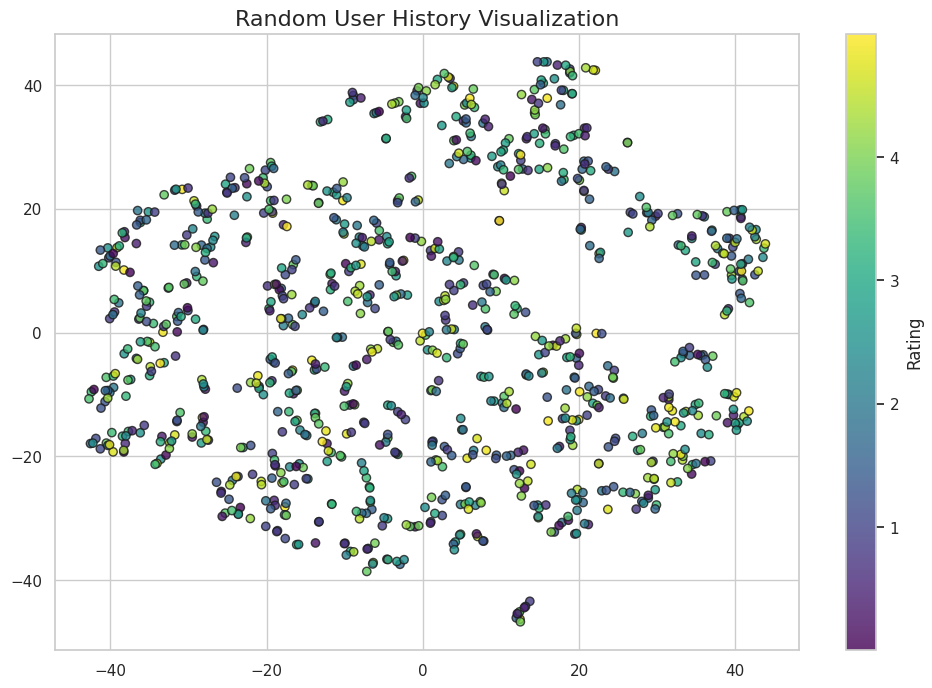

Genre-Based User History Visualization:


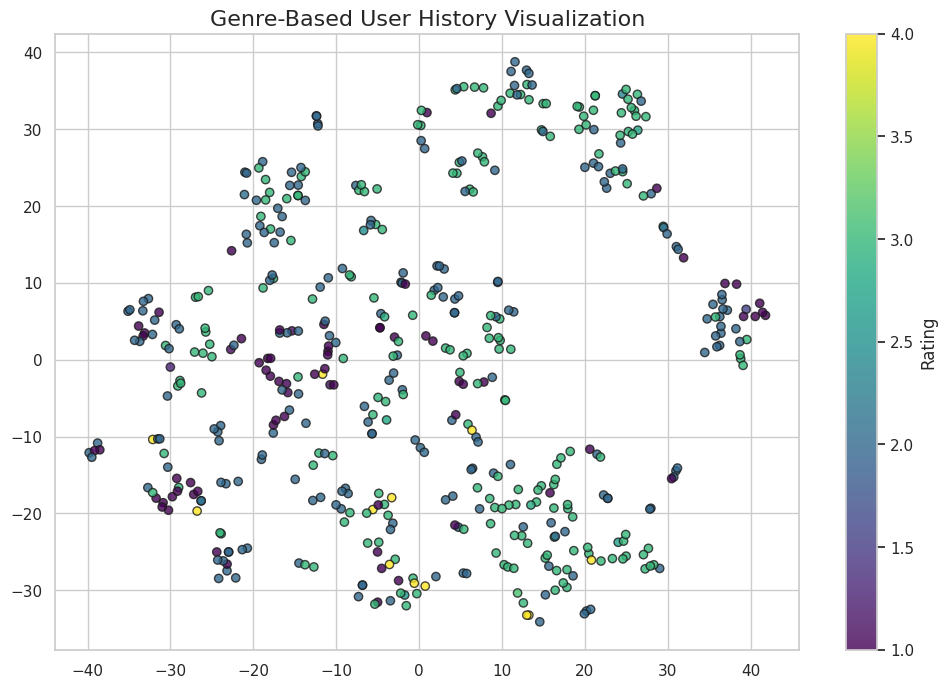

In [ ]:
# Generowanie historii użytkownika
user1_id = 1
user2_id = 2
random_history = generate_random_history(scaled_data, user1_id, n_songs=1000)
genre_based_history = generate_genre_based_history(scaled_data, user2_id, n_songs=500, alpha=0.05)

# Wywołanie funkcji wizualizacyjnej dla obu typów historii
print("Random User History Visualization:")
scatter_songs_with_tsne(random_history, scaled_data, features, 0)

print("Genre-Based User History Visualization:")
scatter_songs_with_tsne(genre_based_history, scaled_data, features, 1)

Klasteryzacja gatunków

Wizualizacja klastrów

In [ ]:
def visualize_clusters_tsne(combined_features, genre_features, clusters, title="Visualization of Genre Clusters with t-SNE"):
    """
    Wizualizacja klastrów za pomocą t-SNE.
    """
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
    reduced_features = tsne.fit_transform(combined_features)

    plt.figure(figsize=(14, 10))

    for cluster in np.unique(clusters):
        cluster_points = reduced_features[clusters == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", alpha=0.7)

    # Dodanie nazw gatunków
    for i, genre in enumerate(genre_features.index):
        plt.text(
            reduced_features[i, 0],
            reduced_features[i, 1],
            genre,
            fontsize=9, alpha=0.8
        )

    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

Cluster 0: ['black-metal', 'death-metal', 'grindcore']
Cluster 1: ['alt-rock', 'alternative', 'anime', 'club', 'dance', 'deep-house', 'detroit-techno', 'dub', 'edm', 'electronic', 'emo', 'garage', 'goth', 'groove', 'hard-rock', 'hardcore', 'house', 'j-idol', 'j-rock', 'power-pop', 'punk', 'punk-rock', 'rock', 'spanish', 'synth-pop', 'trip-hop']
Cluster 2: ['ambient', 'classical', 'new-age', 'opera', 'sleep']
Cluster 3: ['acoustic', 'british', 'cantopop', 'chill', 'comedy', 'indian', 'mandopop', 'show-tunes', 'singer-songwriter', 'study']
Cluster 4: ['german', 'gospel', 'idm', 'iranian', 'world-music']
Cluster 5: ['afrobeat', 'chicago-house', 'dancehall', 'disco', 'funk', 'hip-hop', 'j-dance', 'k-pop', 'kids', 'latin', 'latino', 'party', 'reggae', 'reggaeton', 'ska']
Cluster 6: ['breakbeat', 'drum-and-bass', 'dubstep', 'grunge', 'happy', 'hardstyle', 'heavy-metal', 'industrial', 'metal', 'metalcore', 'minimal-techno', 'progressive-house', 'techno', 'trance']
Cluster 7: ['disney', 'guita

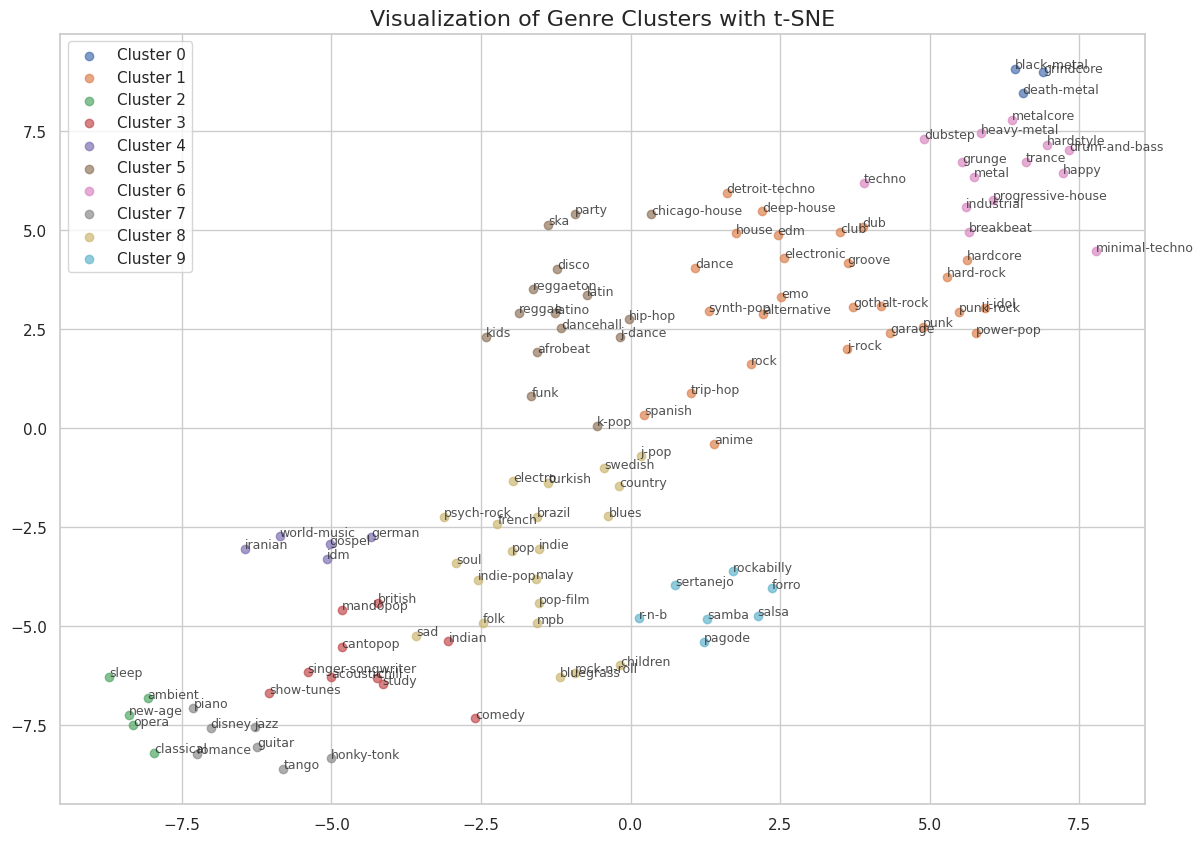

In [ ]:
def main(data, features, n_clusters=10):
    """
    Główna funkcja do przetwarzania i wizualizacji klastrów gatunków.
    """
    # Skalowanie cech
    scaled_data = scale_features(data, features)

    # Przygotowanie osadzeń gatunków
    genre_features, genre_embeddings = prepare_genre_embeddings(scaled_data, features)

    # Połączenie cech
    combined_features = combine_features(genre_features, genre_embeddings)

    # Klasteryzacja
    clusters = cluster_genres(combined_features, n_clusters=n_clusters)

    # Dodanie klastrów do danych
    genre_features["cluster"] = clusters

    # Wyświetlenie gatunków w klastrach
    for cluster_id in range(n_clusters):
        genres_in_cluster = genre_features[genre_features["cluster"] == cluster_id].index.tolist()
        print(f"Cluster {cluster_id}: {genres_in_cluster}")

    # Wizualizacja
    visualize_clusters_tsne(combined_features, genre_features, clusters)


# Wywołanie głównej funkcji
selected_columns = ["track_id", "track_name", "danceability", "energy", "loudness", "acousticness", "valence", "tempo", "time_signature", "track_genre"]
numerical_features = ["danceability", "energy", "loudness", "acousticness", "valence", "tempo", "time_signature"]

main(data[selected_columns], numerical_features, n_clusters=10)

Regresja liniowa

In [ ]:
def perform_linear_regression(user_history, scaled_data, features):
    """
    Przeprowadza regresję liniową na podstawie historii ocen użytkownika.
    Zwraca błąd średniokwadratowy (MSE) dla modelu.
    """
    # Połączenie danych historii z przeskalowanymi danymi
    merged_df = user_history.merge(scaled_data, on="track_id")

    # Przygotowanie zmiennych X (features) i y (rating)
    X = merged_df[features]
    y = merged_df["rating"]

    # Podział na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Regresja liniowa
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Obliczenie błędu średniokwadratowego
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [ ]:
from sklearn.linear_model import SGDRegressor

def perform_sgd_regression(user_history, scaled_data, features, max_iter=1000, learning_rate=0.01):
    """
    Przeprowadza regresję liniową za pomocą SGDRegressor na podstawie historii ocen użytkownika.
    Zwraca błąd średniokwadratowy (MSE) dla modelu.
    """
    # Połączenie danych historii z przeskalowanymi danymi
    merged_df = user_history.merge(scaled_data, on="track_id")

    # Przygotowanie zmiennych X (features) i y (rating)
    X = merged_df[features]
    y = merged_df["rating"]

    # Podział na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Regresja z użyciem SGD
    model = SGDRegressor(max_iter=max_iter, eta0=learning_rate, learning_rate='constant', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Obliczenie błędu średniokwadratowego
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Parametry dla SGD
max_iter = 1000
learning_rate = 0.01

# Wyniki dla losowej historii
mse_random_sgd = perform_sgd_regression(random_history, scaled_data, features, max_iter, learning_rate)
mse_random = perform_linear_regression(random_history, scaled_data, features)

# Wyniki dla historii gatunkowej
mse_genre_sgd = perform_sgd_regression(genre_based_history, scaled_data, features, max_iter, learning_rate)
mse_genre = perform_linear_regression(genre_based_history, scaled_data, features)

# Wyświetlenie wyników
print(f"Mean Squared Error for Random History (Linear Regression): {mse_random}")
print(f"Mean Squared Error for Random History (SGD): {mse_random_sgd}")
print(f"Mean Squared Error for Genre-Based History (Linear Regression): {mse_genre}")
print(f"Mean Squared Error for Genre-Based History (SGD): {mse_genre_sgd}")

Mean Squared Error for Random History (Linear Regression): 2.2038632348192246
Mean Squared Error for Random History (SGD): 2.2626458928349593
Mean Squared Error for Genre-Based History (Linear Regression): 0.4315930702902678
Mean Squared Error for Genre-Based History (SGD): 0.44388081660757145


KNN

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
def predict_ratings_with_knn(user_history, scaled_data, features, k_value):


    # Połączenie danych historii z przeskalowanymi danymi
    merged_df = user_history.merge(scaled_data, on="track_id")

    # Przygotowanie zmiennych X (features) i y (rating)
    X = merged_df[features]
    y = merged_df["rating"]

    # Podział na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #KNN
    knn_model = NearestNeighbors(n_neighbors=k_value, algorithm='auto')
    knn_model.fit(X_train)
    distances, indices = knn_model.kneighbors(X_test)

    y_pred = []
    for i, neighbors in enumerate(indices):  # Dla każdego punktu w zbiorze testowym
        # Pobieramy oceny sąsiadów z y_train
        neighbor_ratings = y_train.iloc[neighbors]

        # Obliczamy średnią ocen sąsiadów
        predicted_rating = np.mean(neighbor_ratings)
        y_pred.append(predicted_rating)

    # Obliczenie błędu średniokwadratowego (MSE)
    mse = mean_squared_error(y_test, y_pred)

    return mse


In [ ]:
mse_genre_based = predict_ratings_with_knn(genre_based_history, scaled_data, features, 5)

In [ ]:
def compare_knn_results(random_history, genre_based_history, scaled_data, features, k_value):
    """
    Porównuje wyniki knn dla dwóch rodzajów historii ocen użytkownika.
    Wyświetla wykres porównujący MSE.
    """
    mse_random = predict_ratings_with_knn(random_history, scaled_data, features, k_value)
    mse_genre_based = predict_ratings_with_knn(genre_based_history, scaled_data, features, k_value)

    # Wizualizacja wyników
    plt.figure(figsize=(8, 6))
    plt.bar(["Random History", "Genre-Based History"], [mse_random, mse_genre_based], color=["blue", "green"])
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Comparison of KNN")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    print(f"Mean Squared Error for Random History: {mse_random}")
    print(f"Mean Squared Error for Genre-Based History: {mse_genre_based}")

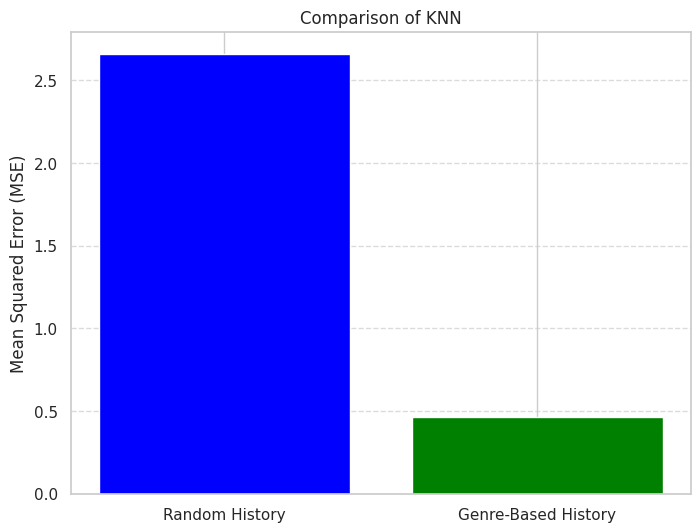

Mean Squared Error for Random History: 2.6599652581323894
Mean Squared Error for Genre-Based History: 0.46410558208047403


In [ ]:
compare_knn_results(random_history, genre_based_history, scaled_data, features, 5)

In [ ]:
def compare_knn_results_for_diff_k_values(random_history, genre_based_history, scaled_data, features):
    """
    Porównuje wyniki KNN dla dwóch rodzajów historii ocen użytkownika i różnych wartości k.
    Wyświetla wykres porównujący MSE w zależności od wartości k.

    """
    k_values = [1, 3, 5, 7, 9, 11, 15, 20]
    mse_random_list = []
    mse_genre_based_list = []

    for k in k_values:
        mse_random = predict_ratings_with_knn(random_history, scaled_data, features, k)
        mse_genre_based = predict_ratings_with_knn(genre_based_history, scaled_data, features, k)

        mse_random_list.append(mse_random)
        mse_genre_based_list.append(mse_genre_based)

    # Wizualizacja wyników
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, mse_random_list, label="Random History", marker="o", color="blue")
    plt.plot(k_values, mse_genre_based_list, label="Genre-Based History", marker="o", color="green")
    plt.xlabel("k (Number of Neighbors)")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Comparison of KNN for Different k Values")
    plt.legend()
    plt.grid(linestyle="--", alpha=0.7)
    plt.show()

    for k, mse_r, mse_g in zip(k_values, mse_random_list, mse_genre_based_list):
        print(f"k={k}: MSE for Random History: {mse_r}, MSE for Genre-Based History: {mse_g}")


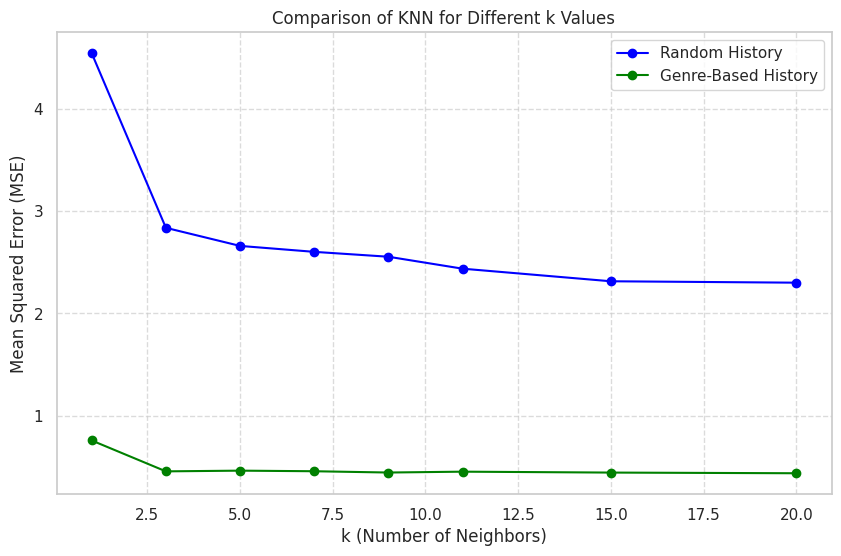

k=1: MSE for Random History: 4.5424794536500706, MSE for Genre-Based History: 0.7588387232951664
k=3: MSE for Random History: 2.8368525550942536, MSE for Genre-Based History: 0.45722382806015965
k=5: MSE for Random History: 2.6599652581323894, MSE for Genre-Based History: 0.46410558208047403
k=7: MSE for Random History: 2.6020204646294416, MSE for Genre-Based History: 0.4583360497665959
k=9: MSE for Random History: 2.5542645791188376, MSE for Genre-Based History: 0.44574333352225104
k=11: MSE for Random History: 2.4375307008401164, MSE for Genre-Based History: 0.4541392025702883
k=15: MSE for Random History: 2.3144947881398283, MSE for Genre-Based History: 0.4452855337889264
k=20: MSE for Random History: 2.3007711974448086, MSE for Genre-Based History: 0.43870900109469924


In [ ]:
compare_knn_results_for_diff_k_values(random_history, genre_based_history, scaled_data, features)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def perform_random_forest_regression(user_history, scaled_data, features, n_estimators=100):
    """
    Przeprowadza regresję za pomocą Random Forest na podstawie historii ocen użytkownika.
    Zwraca błąd średniokwadratowy (MSE) dla modelu.
    """
    # Połączenie danych historii z przeskalowanymi danymi
    merged_df = user_history.merge(scaled_data, on="track_id")

    # Przygotowanie zmiennych X (features) i y (rating)
    X = merged_df[features]
    y = merged_df["rating"]

    # Podział na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest Regressor
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Obliczenie błędu średniokwadratowego
    mse = mean_squared_error(y_test, y_pred)
    return mse

mse_forest_random = perform_random_forest_regression(random_history, scaled_data, features)
mse_forest_genre_based = perform_random_forest_regression(genre_based_history, scaled_data, features)

# Wyświetlenie wyników
print(f"Mean Squared Error for Random History (Random Forest): {mse_forest_random}")
print(f"Mean Squared Error for Genre-Based History (Random Forest): {mse_forest_genre_based}")

Mean Squared Error for Random History (Random Forest): 2.387568702302868
Mean Squared Error for Genre-Based History (Random Forest): 0.45548914864329626


In [ ]:
def semi_final_boss():
    mse_knn_random_list = []
    mse_knn_genre_based_list = []

    mse_reg_random_list = []
    mse_reg_genre_based_list = []

    mse_forest_random_list = []
    mse_forest_genre_based_list = []

    mse_sgd_random_list = []
    mse_sgd_genre_based_list = []

    history_sizes = range(50, 1000, 50)

    for history_size in history_sizes:
        # print(f"History size: {history_size}")
        # Generowanie historii użytkownika
        user1_id = 1
        user2_id = 2

        random_history = generate_random_history(scaled_data, user1_id, n_songs=history_size)
        genre_based_history = generate_genre_based_history(scaled_data, user2_id, n_songs=history_size, alpha=0.05)

        k_values = [1, 3, 5, 7, 9, 11, 15, 20]
        k_random_list = []
        k_genre_based_list = []

        for k in k_values:
            mse_random = predict_ratings_with_knn(random_history, scaled_data, features, k)
            mse_genre_based = predict_ratings_with_knn(genre_based_history, scaled_data, features, k)

            k_random_list.append(mse_random)
            k_genre_based_list.append(mse_genre_based)

        mse_knn_random = min(k_random_list)
        mse_knn_genre_based = min(k_genre_based_list)


        # mse_knn_random = predict_ratings_with_knn(random_history, scaled_data, features, 7)
        # mse_knn_genre_based = predict_ratings_with_knn(genre_based_history, scaled_data, features, 7)

        mse_knn_random_list.append(mse_knn_random)
        mse_knn_genre_based_list.append(mse_knn_genre_based)

        mse_reg_random = perform_linear_regression(random_history, scaled_data, features)
        mse_reg_genre_based = perform_linear_regression(genre_based_history, scaled_data, features)

        mse_reg_random_list.append(mse_reg_random)
        mse_reg_genre_based_list.append(mse_reg_genre_based)

        mse_forest_random = perform_random_forest_regression(random_history, scaled_data, features)
        mse_forest_genre_based = perform_random_forest_regression(genre_based_history, scaled_data, features)

        mse_forest_random_list.append(mse_forest_random)
        mse_forest_genre_based_list.append(mse_forest_genre_based)

        mse_sgd_random = perform_sgd_regression(random_history, scaled_data, features)
        mse_sgd_genre_based = perform_sgd_regression(genre_based_history, scaled_data, features)

        mse_sgd_random_list.append(mse_sgd_random)
        mse_sgd_genre_based_list.append(mse_sgd_genre_based)

    # Wizualizacja wyników
    plt.figure(figsize=(10, 6))
    plt.plot(history_sizes, mse_knn_random_list, label="Random History - knn", marker="o", color="blue")
    plt.plot(history_sizes, mse_knn_genre_based_list, label="Genre-Based History - knn", marker="o", color="green")
    plt.plot(history_sizes, mse_reg_random_list, label="Random History - reg", marker="o", color="red")
    plt.plot(history_sizes, mse_reg_genre_based_list, label="Genre-Based History - reg", marker="o", color="orange")
    plt.plot(history_sizes, mse_forest_random_list, label="Random History - forest", marker="o", color="purple")
    plt.plot(history_sizes, mse_forest_genre_based_list, label="Genre-Based History - forest", marker="o", color="pink")
    plt.plot(history_sizes, mse_sgd_random_list, label="Random History - SGD", marker="o", color="brown")
    plt.plot(history_sizes, mse_sgd_genre_based_list, label="Genre-Based History - SGD", marker="o", color="gray")
    plt.xlabel("size of history")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("Comparison of KNN and linear regression for Different history sizes")
    plt.legend(loc = "best")
    plt.grid(linestyle="--", alpha=0.7)
    plt.show()

    # for k, mse_r, mse_g in zip(history_sizes, mse_knn_random_list, mse_knn_genre_based_list):
    #     print(f"k={k}: MSE for Random History: {mse_r}, MSE for Genre-Based History: {mse_g}")

    return mse_knn_random_list, mse_knn_genre_based_list, mse_reg_random_list, mse_reg_genre_based_list, mse_forest_random_list, mse_forest_genre_based_list, mse_sgd_random_list, mse_sgd_genre_based_list



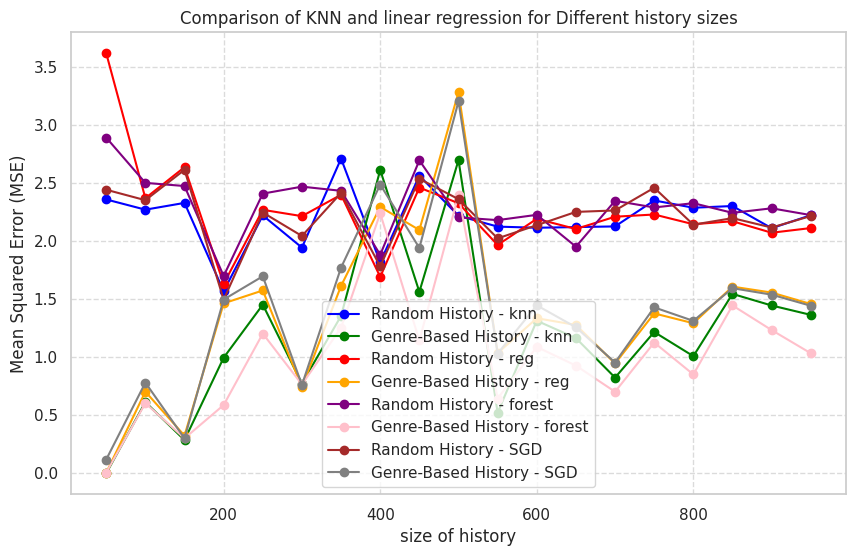

In [ ]:
semi_final_boss()
print()

In [ ]:
def semi_final_boss_2():
    mse_knn_random_list = []
    mse_knn_genre_based_list = []

    mse_reg_random_list = []
    mse_reg_genre_based_list = []

    mse_forest_random_list = []
    mse_forest_genre_based_list = []

    mse_sgd_random_list = []
    mse_sgd_genre_based_list = []

    history_sizes = range(100, 1000, 100)

    for history_size in history_sizes:
        print(f"History size: {history_size}")
        # Generowanie historii użytkownika
        user1_id = 1
        user2_id = 2

        random_history = generate_random_history(scaled_data, user1_id, n_songs=history_size)
        genre_based_history = generate_genre_based_history(scaled_data, user2_id, n_songs=history_size, alpha=0.05)

        k_values = [1, 3, 5, 7, 9, 11, 15, 20]
        k_random_list = []
        k_genre_based_list = []

        for k in k_values:
            mse_random = predict_ratings_with_knn(random_history, scaled_data, features, k)
            mse_genre_based = predict_ratings_with_knn(genre_based_history, scaled_data, features, k)

            k_random_list.append(mse_random)
            k_genre_based_list.append(mse_genre_based)

        mse_knn_random = min(k_random_list)
        mse_knn_genre_based = min(k_genre_based_list)


        # mse_knn_random = predict_ratings_with_knn(random_history, scaled_data, features, 7)
        # mse_knn_genre_based = predict_ratings_with_knn(genre_based_history, scaled_data, features, 7)

        mse_knn_random_list.append(mse_knn_random)
        mse_knn_genre_based_list.append(mse_knn_genre_based)

        mse_reg_random = perform_linear_regression(random_history, scaled_data, features)
        mse_reg_genre_based = perform_linear_regression(genre_based_history, scaled_data, features)

        mse_reg_random_list.append(mse_reg_random)
        mse_reg_genre_based_list.append(mse_reg_genre_based)

        mse_forest_random = perform_random_forest_regression(random_history, scaled_data, features)
        mse_forest_genre_based = perform_random_forest_regression(genre_based_history, scaled_data, features)

        mse_forest_random_list.append(mse_forest_random)
        mse_forest_genre_based_list.append(mse_forest_genre_based)

        mse_sgd_random = perform_sgd_regression(random_history, scaled_data, features)
        mse_sgd_genre_based = perform_sgd_regression(genre_based_history, scaled_data, features)

        mse_sgd_random_list.append(mse_sgd_random)
        mse_sgd_genre_based_list.append(mse_sgd_genre_based)


    # for k, mse_r, mse_g in zip(history_sizes, mse_knn_random_list, mse_knn_genre_based_list):
    #     print(f"k={k}: MSE for Random History: {mse_r}, MSE for Genre-Based History: {mse_g}")

    return mse_knn_random_list, mse_knn_genre_based_list, mse_reg_random_list, mse_reg_genre_based_list, mse_forest_random_list, mse_forest_genre_based_list, mse_sgd_random_list, mse_sgd_genre_based_list



In [ ]:
def run_experiment(n_runs=10):
    """
    Funkcja uruchamia `semi_final_boss` wielokrotnie, oblicza średnie wartości MSE
    i wyświetla wykres.
    """
    history_sizes = range(100, 1000, 100)

    # Inicjalizacja tablic do przechowywania sum wyników
    avg_knn_random = [0] * len(history_sizes)
    avg_knn_genre_based = [0] * len(history_sizes)

    avg_reg_random = [0] * len(history_sizes)
    avg_reg_genre_based = [0] * len(history_sizes)

    avg_forest_random = [0] * len(history_sizes)
    avg_forest_genre_based = [0] * len(history_sizes)

    avg_sgd_random = [0] * len(history_sizes)
    avg_sgd_genre_based = [0] * len(history_sizes)

    for run in range(n_runs):
        print(f"Run {run + 1} / {n_runs}")
        mse_knn_random, mse_knn_genre_based, mse_reg_random, mse_reg_genre_based, mse_forest_random, mse_forest_genre_based, mse_sgd_random, mse_sgd_genre_based = semi_final_boss_2()

        # Sumowanie wyników z każdego uruchomienia
        avg_knn_random = [sum(x) for x in zip(avg_knn_random, mse_knn_random)]
        avg_knn_genre_based = [sum(x) for x in zip(avg_knn_genre_based, mse_knn_genre_based)]

        avg_reg_random = [sum(x) for x in zip(avg_reg_random, mse_reg_random)]
        avg_reg_genre_based = [sum(x) for x in zip(avg_reg_genre_based, mse_reg_genre_based)]

        avg_forest_random = [sum(x) for x in zip(avg_forest_random, mse_forest_random)]
        avg_forest_genre_based = [sum(x) for x in zip(avg_forest_genre_based, mse_forest_genre_based)]

        avg_sgd_random = [sum(x) for x in zip(avg_sgd_random, mse_sgd_random)]
        avg_sgd_genre_based = [sum(x) for x in zip(avg_sgd_genre_based, mse_sgd_genre_based)]

    # Obliczanie średnich
    avg_knn_random = [x / n_runs for x in avg_knn_random]
    avg_knn_genre_based = [x / n_runs for x in avg_knn_genre_based]

    avg_reg_random = [x / n_runs for x in avg_reg_random]
    avg_reg_genre_based = [x / n_runs for x in avg_reg_genre_based]

    avg_forest_random = [x / n_runs for x in avg_forest_random]
    avg_forest_genre_based = [x / n_runs for x in avg_forest_genre_based]

    avg_sgd_random = [x / n_runs for x in avg_sgd_random]
    avg_sgd_genre_based = [x / n_runs for x in avg_sgd_genre_based]

    # Wizualizacja wyników
    plt.figure(figsize=(10, 6))
    plt.plot(history_sizes, avg_knn_random, label="Random History - knn", marker="o", color="blue")
    plt.plot(history_sizes, avg_knn_genre_based, label="Genre-Based History - knn", marker="o", color="green")
    plt.plot(history_sizes, avg_reg_random, label="Random History - reg", marker="o", color="red")
    plt.plot(history_sizes, avg_reg_genre_based, label="Genre-Based History - reg", marker="o", color="orange")
    plt.plot(history_sizes, avg_forest_random, label="Random History - forest", marker="o", color="purple")
    plt.plot(history_sizes, avg_forest_genre_based, label="Genre-Based History - forest", marker="o", color="pink")
    plt.plot(history_sizes, avg_sgd_random, label="Random History - SGD", marker="o", color="brown")
    plt.plot(history_sizes, avg_sgd_genre_based, label="Genre-Based History - SGD", marker="o", color="gray")
    plt.xlabel("size of history")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title(f"Average MSE over {n_runs} runs")
    plt.legend()
    plt.grid(linestyle="--", alpha=0.7)
    plt.show()


Run 1 / 10
History size: 100
History size: 200
History size: 300
History size: 400
History size: 500
History size: 600
History size: 700
History size: 800
History size: 900
Run 2 / 10
History size: 100
History size: 200
History size: 300
History size: 400
History size: 500
History size: 600
History size: 700
History size: 800
History size: 900
Run 3 / 10
History size: 100
History size: 200
History size: 300
History size: 400
History size: 500
History size: 600
History size: 700
History size: 800
History size: 900
Run 4 / 10
History size: 100
History size: 200
History size: 300
History size: 400
History size: 500
History size: 600
History size: 700
History size: 800
History size: 900
Run 5 / 10
History size: 100
History size: 200
History size: 300
History size: 400
History size: 500
History size: 600
History size: 700
History size: 800
History size: 900
Run 6 / 10
History size: 100
History size: 200
History size: 300
History size: 400
History size: 500
History size: 600
History size: 70

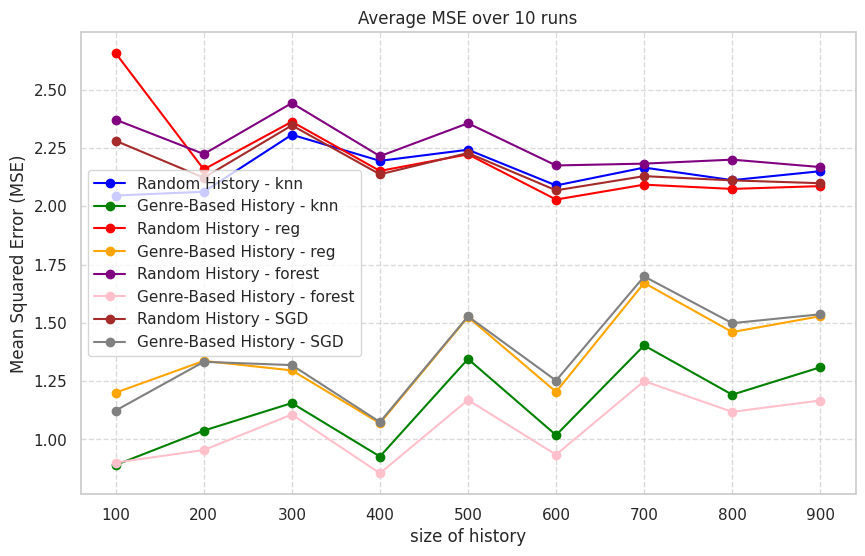

In [ ]:
run_experiment()

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

def predict_top_songs(user_history, scaled_data, features, n_top_songs=10):
    """
    Przewiduje najlepsze utwory na podstawie historii użytkownika
    za pomocą regresji Random Forest. Zwraca najlepsze piosenki w ładnej tabeli.
    """
    merged_df = user_history.merge(scaled_data, on="track_id")

    X = merged_df[features]
    y = merged_df["rating"]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    predictions = model.predict(scaled_data[features])

    scaled_data["predicted_rating"] = predictions

    unscored_songs = scaled_data[~scaled_data["track_id"].isin(user_history["track_id"])]

    top_songs = unscored_songs[["track_id", "predicted_rating"]].merge(data[["track_id", "track_name", "artists"]], on="track_id")

    top_songs = top_songs.sort_values(by="predicted_rating", ascending=False).head(n_top_songs)

    styled_table = top_songs[["track_name", "artists", "predicted_rating"]].style.format({
        "predicted_rating": "{:.2f}"
    }).hide(axis="index").set_table_attributes('class="table table-striped"')

    return styled_table

top_songs_genre_based_history = predict_top_songs(genre_based_history, scaled_data, features, n_top_songs=10)

top_songs_genre_based_history


track_name,artists,predicted_rating
anestesia / na nossa sala / fica à vontade / amor de fim de noite - ao vivo,di propósito,3.47
kisi din banoongi main,alka yagnik;udit narayan,3.45
apthero awastha,bekcha,3.45
lalitha sahasranama sthothram,priya sisters,3.44
uma prova de amor - ao vivo,zeca pagodinho,3.44
months of the year song,kids tv 123,3.43
country girl,faron young,3.43
tentei ser incrível,ferrugem,3.42
duas paixões / shortinho saint-tropez - ao vivo,turma do pagode,3.42
serrado (ao vivo),djavan,3.41
